<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/Jeju_bigdata03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용자 계정 인증

In [7]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


###데이터 불러오기

빅쿼리 → 랜덤 샘플링

In [12]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'jeju-bigquery-282708'
client = bigquery.Client(project = 'jeju-bigquery-282708')

train = client.query('''
  SELECT 
      * 
  FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train` 
  WHERE RAND() < 1000 / (SELECT COUNT(*) FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train`)
  ''').to_dataframe()

In [13]:
train

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201909,대전,유성구,한식 음식점업,강원,춘천시,30s,1,2,8,761100,14
1,201901,서울,양천구,피자 햄버거 샌드위치 및 유사 음식점업,경기,고양시 덕양구,20s,1,1,18,270500,25
2,201902,경북,안동시,피자 햄버거 샌드위치 및 유사 음식점업,경기,양평군,20s,1,1,3,46950,4
3,201904,서울,강남구,피자 햄버거 샌드위치 및 유사 음식점업,경기,용인시 수지구,20s,1,1,247,2776180,335
4,201906,경기,수원시 장안구,빵 및 과자류 소매업,경기,군포시,20s,1,1,6,33400,9
...,...,...,...,...,...,...,...,...,...,...,...,...
1016,201907,경남,사천시,스포츠 및 레크레이션 용품 임대업,충남,금산군,50s,1,4,3,113000,5
1017,201905,대전,서구,피자 햄버거 샌드위치 및 유사 음식점업,충남,계룡시,50s,1,4,29,642800,52
1018,201904,전남,여수시,한식 음식점업,충북,청주시 청원구,20s,1,1,4,335000,6
1019,201912,울산,울주군,차량용 주유소 운영업,충북,청주시 서원구,30s,1,2,3,136000,3


###데이터 시각화 하기

In [14]:
from pandas_profiling import ProfileReport

profile = ProfileReport(train, title = 'Pandas Profiling Report', explorative = True)
profile.to_notebook_iframe()

###머신러닝, 시각화, 통계 패키지 로드

In [15]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 평가 메트릭
# MSE : 제곱값이기 때문에 특이치에 민감
# MAE : 절대값을 취하기 때문에 가장 직관적(하지만 underperformance인지 over인지 확인 불가)
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib.pyplot as plt

# 통계
from scipy import stats
from scipy.stats import norm, skew # norm : 정규분포, skew : 피어슨의 비대칭계수

In [16]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
Python 3.6.9


###날짜 데이터 전처리

In [17]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [18]:
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201909
1    201901
2    201902
3    201904
4    201906
Name: REG_YYMM, dtype: int64


In [19]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,대전,유성구,한식 음식점업,강원,춘천시,30s,1,2,8,761100,14,2019,9
1,서울,양천구,피자 햄버거 샌드위치 및 유사 음식점업,경기,고양시 덕양구,20s,1,1,18,270500,25,2019,1
2,경북,안동시,피자 햄버거 샌드위치 및 유사 음식점업,경기,양평군,20s,1,1,3,46950,4,2019,2
3,서울,강남구,피자 햄버거 샌드위치 및 유사 음식점업,경기,용인시 수지구,20s,1,1,247,2776180,335,2019,4
4,경기,수원시 장안구,빵 및 과자류 소매업,경기,군포시,20s,1,1,6,33400,9,2019,6


### 시군구 컬럼 제거

In [20]:
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)

columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [21]:
df

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,강원,골프장 운영업,경기,30s,1,2,2019,10,3,40200,3
1,강원,기타 대형 종합 소매업,서울,50s,1,4,2019,10,6,243760,10
2,강원,기타 외국식 음식점업,강원,30s,1,2,2019,7,153,4969570,181
3,강원,기타음식료품위주종합소매업,서울,40s,1,3,2019,6,4,207370,6
4,강원,비알콜 음료점업,강원,40s,1,3,2019,6,13,103400,13
...,...,...,...,...,...,...,...,...,...,...,...
1012,충북,한식 음식점업,대구,40s,1,4,2019,6,7,48000,7
1013,충북,한식 음식점업,서울,30s,1,2,2020,2,3,6000,4
1014,충북,한식 음식점업,서울,60s,1,5,2020,2,6,32800,8
1015,충북,한식 음식점업,충북,20s,2,1,2019,3,1047,42061810,1923


###RMSLE

RMSE(Root Mean Square Error)에 로그를 취한 지표.

sklearn → RMSLE 존재 X. 직접 함수 생성.

log값 변환 시 nan과 같은 값 발생으로 인해 log1p()사용(np.expm1()로 다시 복원 가능)

In [22]:
# RMSLE 함수 생성
def rmsle(y, pred):
  log_y = np.log1p(y) # 실제값에 1 더한 뒤 로그
  log_pred = np.log1p(pred) # 예측값에 1 더한 뒤 로그
  squared_error = (log_y - log_pred)**2 # 오차 제곱
  rmsle = np.sqrt(np.mean(squared_error)) # 위의 값의 평균을 구한 뒤 루트
  return rmsle

###종속 변수 확인
라벨 인코딩 전에 타겟 변수(종속 변수) 모양 확인

타겟 변수의 분포가 왜곡되어있을 경우 예측 성능이 저하됨


 mu = 3289174.24 and sigma = 30158188.11



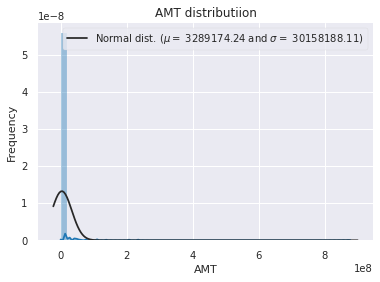

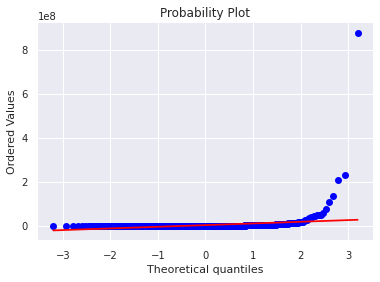

In [23]:
sns.distplot(df['AMT'], fit = norm);
(mu, sigma) = norm.fit(df['AMT'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('AMT distributiion')

fig = plt.figure()
res = stats.probplot(df['AMT'], plot = plt)
plt.show()


 mu = 2.61 and sigma = 0.13



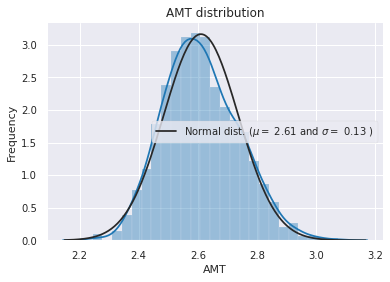

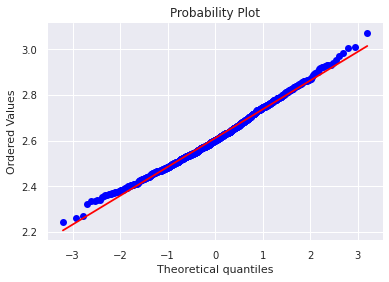

In [25]:
# 타겟 변수 정규화
df["AMT"] = np.log1p(df["AMT"])

sns.distplot(df['AMT'] , fit=norm);
(mu, sigma) = norm.fit(df['AMT'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(df['AMT'], plot=plt)
plt.show()

###라벨 인코딩

In [26]:
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

###변수 선택 및 모델 구축

In [27]:
train_num = df_num.sample(frac=1, random_state=0)
train_features = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
train_target = train_num['AMT']

###하이퍼 파라미터 및 튜닝

In [28]:
gbm = GradientBoostingRegressor(n_estimators=4000);
gbm.fit(train_features, train_target)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

###예측 템플릿 작성

In [29]:
from itertools import product

CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [30]:
pred = gbm.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [31]:
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

temp.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,12948.0
1,202004,강원,골프장 운영업,13701.0
2,202004,강원,과실 및 채소 소매업,13646.0
3,202004,강원,관광 민예품 및 선물용품 소매업,13072.0
4,202004,강원,그외 기타 종합 소매업,16113.0


###Submission 파일 작업 및 내보내기

In [33]:
submission = client.query('''
  SELECT 
    * 
  FROM `jeju-bigquery-282708.jeju_bigdata.submission` 
  ''').to_dataframe()

In [34]:
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission['AMT'] = submission['AMT'].fillna(0)
submission.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,12948.0
1,1,202004,강원,골프장 운영업,13701.0
2,2,202004,강원,과실 및 채소 소매업,13646.0
3,3,202004,강원,관광 민예품 및 선물용품 소매업,13072.0
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.0


In [35]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/jeju/submission03.csv', encoding='utf-8-sig', index=False)